In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from psyrun.store.npz import NpzStore
import seaborn as sns

In [3]:
sns.set('paper', 'ticks')

In [4]:
neuron_type_order = ['LIF', 'Direct']
backend_order = ['reference', 'optimized', 'ocl_cpu', 'ocl_gpu']

## Circular convolution network

In [5]:
df = pd.DataFrame(NpzStore().load('../data/time_cconv.npz')).query('neuron_type != "LIFRate"')

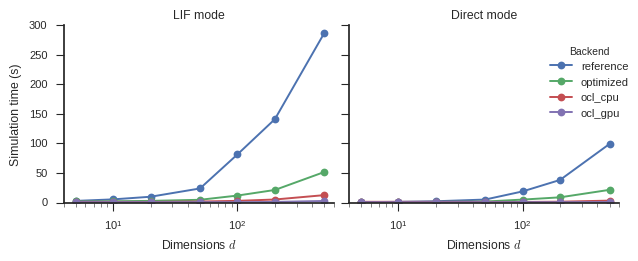

In [6]:
g = sns.FacetGrid(
    df.query('model == "circ_conv" and n_neurons == 500'),
    col='neuron_type', col_order=neuron_type_order,
    hue='backend', hue_order=backend_order,
    size=7. / 2.54)
def lineplot(x, y, unit, condition, data, **kwargs):
    del kwargs['label']
    data = data.reset_index()
    return sns.tsplot(
        time=x, value=y, unit=unit, condition=condition, data=data,
        marker='o', err_style='ci_bars',
        **kwargs)
    
g.map_dataframe(lineplot, 'dimensions', 't_sim', unit='trial', condition='backend')
g.map(plt.semilogx)
g.set(xlim=(4, 600))
g.set_titles("{col_name} mode")
g.set_axis_labels("Dimensions $d$", "Simulation time (s)")
g.add_legend(title="Backend", bbox_to_anchor=(1, 0.65))
plt.tight_layout()
plt.savefig('../figures/cconv_sim.pdf')

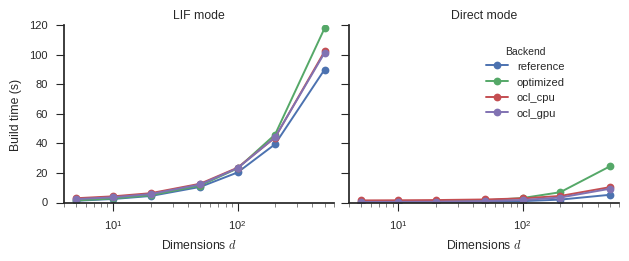

In [7]:
g = sns.FacetGrid(
    df.query('model == "circ_conv" and n_neurons == 500'),
    col='neuron_type', col_order=neuron_type_order,
    hue='backend', hue_order=backend_order,
    size=7. / 2.54)
def lineplot(x, y, unit, condition, data, **kwargs):
    del kwargs['label']
    data = data.reset_index()
    return sns.tsplot(
        time=x, value=y, unit=unit, condition=condition, data=data,
        marker='o', err_style='ci_bars',
        **kwargs)
    
g.map_dataframe(lineplot, 'dimensions', 't_build', unit='trial', condition='backend')
g.map(plt.semilogx)
g.set(xlim=(4, 600))
g.set_titles("{col_name} mode")
g.set_axis_labels("Dimensions $d$", "Build time (s)")
g.add_legend(title="Backend", bbox_to_anchor=(.9, 0.65))
plt.tight_layout()
plt.savefig('../figures/cconv_build.pdf')

In [8]:
df.query('model == "circ_conv" and n_neurons == 500 and dimensions == 500').groupby(['neuron_type', 'backend']).mean()

dimensions  n_neurons     t_build  t_prefill  \
neuron_type backend                                                   
Direct      ocl_cpu         500.0        500   10.436626   0.074876   
            ocl_gpu         500.0        500    9.358922   0.018178   
            optimized       500.0        500   24.456344   0.140719   
            reference       500.0        500    5.283300   0.912235   
LIF         ocl_cpu         500.0        500  102.210995   0.171577   
            ocl_gpu         500.0        500  101.275323   0.036499   
            optimized       500.0        500  117.864450   0.504360   
            reference       500.0        500   89.945869   2.861928   

                            t_sim  trial  
neuron_type backend                       
Direct      ocl_cpu      3.432275      2  
            ocl_gpu      1.017855      2  
            optimized   21.628215      2  
            reference   99.238818      2  
LIF         ocl_cpu     12.716431      2  
            ocl_gpu      2.840240      2  
            optimized   51.851467      2  
            reference  287.077849      2

In [9]:
df.query('model == "circ_conv" and n_neurons == 500 and '
         '((neuron_type == "Direct" and backend == "reference") or '
         '(neuron_type == "LIF" and backend == "optimized"))').groupby(
    ['neuron_type', 'backend', 'dimensions']).mean()

n_neurons     t_build  t_prefill      t_sim  \
neuron_type backend   dimensions                                                
Direct      reference 5.0               500    0.073487   0.007967   0.786008   
                      10.0              500    0.143376   0.013800   1.366180   
                      20.0              500    0.234236   0.023440   2.335915   
                      50.0              500    0.494084   0.052036   5.214731   
                      100.0             500    1.011133   0.123997  18.971968   
                      200.0             500    2.044871   0.322137  38.339779   
                      500.0             500    5.283300   0.912235  99.238818   
LIF         optimized 5.0               500    1.475311   0.019613   1.959350   
                      10.0              500    2.813969   0.023292   2.339193   
                      20.0              500    5.013743   0.029568   2.982266   
                      50.0              500   11.526083   0.047551   4.824088   
                      100.0             500   23.180437   0.114847  11.973735   
                      200.0             500   46.017108   0.210040  21.448699   
                      500.0             500  117.864450   0.504360  51.851467   

                                  trial  
neuron_type backend   dimensions         
Direct      reference 5.0             2  
                      10.0            2  
                      20.0            2  
                      50.0            2  
                      100.0           2  
                      200.0           2  
                      500.0           2  
LIF         optimized 5.0             2  
                      10.0            2  
                      20.0            2  
                      50.0            2  
                      100.0           2  
                      200.0           2  
                      500.0           2

In [10]:
def speedup(df, col, base='reference', cmp='optimized'):
    a = df.query('backend == {!r}'.format(base)).groupby('dimensions').mean()
    b = df.query('backend == {!r}'.format(cmp)).groupby('dimensions').mean()
    return a[col] / b[col]

In [11]:
# LIF simulation speedup
speedup(df.query('model == "circ_conv" and n_neurons == 500 and neuron_type == "LIF"'), 't_sim')

dimensions
5.0      1.493573
10.0     2.363233
20.0     3.345925
50.0     4.970216
100.0    6.814382
200.0    6.581568
500.0    5.536542
Name: t_sim, dtype: float64

In [12]:
# LIF build slow down
1. / speedup(df.query('model == "circ_conv" and n_neurons == 500 and neuron_type == "LIF"'), 't_build')

dimensions
5.0      1.185412
10.0     1.137195
20.0     1.116869
50.0     1.085439
100.0    1.135835
200.0    1.165014
500.0    1.310393
Name: t_build, dtype: float64

In [13]:
# Direct mode speed up
speedup(df.query('model == "circ_conv" and n_neurons == 500 and neuron_type == "Direct"'), 't_sim')

dimensions
5.0      0.905741
10.0     1.382483
20.0     1.926889
50.0     2.817858
100.0    3.683815
200.0    4.269371
500.0    4.588396
Name: t_sim, dtype: float64

In [14]:
# Direct mode slow down
1. / speedup(df.query('model == "circ_conv" and n_neurons == 500 and neuron_type == "Direct"'), 't_build')

dimensions
5.0      3.335191
10.0     2.776271
20.0     2.779183
50.0     3.036400
100.0    3.102486
200.0    3.439014
500.0    4.628990
Name: t_build, dtype: float64

## n-back task model

In [15]:
df = pd.DataFrame(NpzStore().load('../data/time_nback.npz')).query('neuron_type != "LIFRate"')
df['splits'] = 64 // df['sd']
df.columns

Index(['backend', 'model', 'neuron_type', 'sd', 't_build', 't_prefill',
       't_sim', 'trial', 'splits'],
      dtype='object')

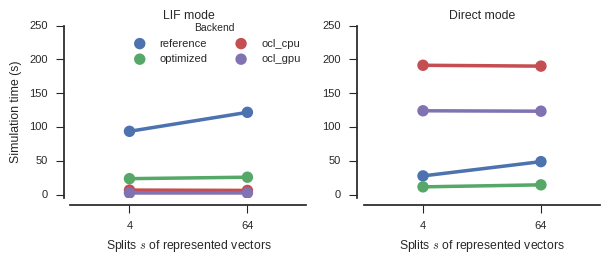

In [16]:
g = sns.FacetGrid(
    df.query('model == "nback"'),
    col='neuron_type', col_order=neuron_type_order,
    size=7. / 2.54, aspect=0.8)
    
g.map_dataframe(
    sns.pointplot, 'splits', 't_sim',
    hue='backend', hue_order=backend_order,
    palette='deep')
g.set(ylim=(-5, 250))
g.set_titles("{col_name} mode")
g.set_axis_labels("Splits $s$ of represented vectors", "Simulation time (s)")
g.add_legend(title="Backend", bbox_to_anchor=(.5, 0.8), ncol=2, label_order=backend_order)
g.despine(offset=5)
plt.tight_layout()
plt.savefig('../figures/nback_sim.pdf')

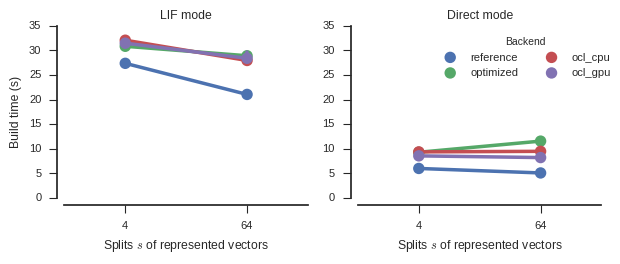

In [17]:
g = sns.FacetGrid(
    df.query('model == "nback"'),
    col='neuron_type', col_order=neuron_type_order,
    size=7. / 2.54, aspect=.8)
    
g.map_dataframe(
    sns.pointplot, 'splits', 't_build',
    hue='backend', hue_order=backend_order,
    palette='deep')
g.set_titles("{col_name} mode")
g.set_axis_labels("Splits $s$ of represented vectors", "Build time (s)")
g.add_legend(title="Backend", bbox_to_anchor=(1, 0.75), label_order=backend_order, ncol=2)
g.despine(offset=5)
plt.tight_layout()
plt.savefig('../figures/nback_build.pdf')

In [18]:
df.query('model == "nback"').groupby(['splits', 'neuron_type', 'backend']).mean()

sd    t_build  t_prefill       t_sim  trial
splits neuron_type backend                                               
4      Direct      ocl_cpu    16   9.365076   1.995665  191.385469      2
                   ocl_gpu    16   8.556367   1.250433  124.053675      2
                   optimized  16   9.289028   0.116571   11.484905      2
                   reference  16   6.001116   0.279673   27.682907      2
       LIF         ocl_cpu    16  32.045944   0.083115    6.710504      2
                   ocl_gpu    16  31.442273   0.025366    2.415309      2
                   optimized  16  30.809748   0.235388   23.617817      2
                   reference  16  27.349473   0.936517   93.662983      2
64     Direct      ocl_cpu     1   9.478429   1.943831  190.111183      2
                   ocl_gpu     1   8.211449   1.241604  123.435753      2
                   optimized   1  11.551397   0.146730   14.473749      2
                   reference   1   5.088148   0.493738   48.795645      2
       LIF         ocl_cpu     1  27.929542   0.069252    6.209856      2
                   ocl_gpu     1  28.370127   0.025461    2.437980      2
                   optimized   1  28.886931   0.256156   25.759856      2
                   reference   1  21.035313   1.223405  121.760106      2

## Spaun

In [19]:
df = pd.DataFrame(NpzStore().load('../data/time_spaun.npz')).query('neuron_type != "LIFRate"')

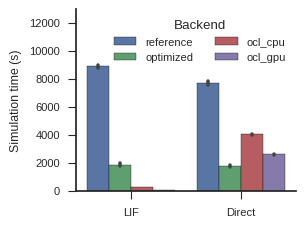

In [20]:
fig = plt.figure(figsize=(8. / 2.54, 6. / 2.54))
sns.barplot('neuron_type', 't_sim', hue='backend', data=df, hue_order=backend_order, order=neuron_type_order)
sns.despine()
plt.xlabel("")
plt.ylabel("Simulation time (s)")
plt.ylim(0, 1.3e4)
plt.legend(loc='best', ncol=2, title="Backend")
plt.tight_layout()
plt.savefig('../figures/spaun_sim.pdf')

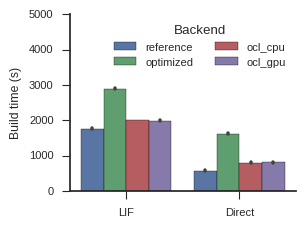

In [21]:
fig = plt.figure(figsize=(8. / 2.54, 6. / 2.54))
sns.barplot('neuron_type', 't_build', hue='backend', data=df, hue_order=backend_order, order=neuron_type_order)
sns.despine()
plt.xlabel("")
plt.ylabel("Build time (s)")
plt.ylim(0, 5e3)
plt.legend(loc='best', ncol=2, title="Backend")
plt.tight_layout()
plt.savefig('../figures/spaun_build.pdf')

In [22]:
df.query('model == "spaun"').groupby(['neuron_type', 'backend']).mean()

t_build  t_prefill        t_sim  trial
neuron_type backend                                              
Direct      ocl_cpu     801.821968  40.678058  4046.089262      2
            ocl_gpu     803.960797  26.344725  2606.584386      2
            optimized  1614.988744  17.552260  1799.970410      2
            reference   576.823606  77.229647  7722.855351      2
LIF         ocl_cpu    1999.628567   2.821676   286.390783      2
            ocl_gpu    1989.660312   0.657224    65.694064      2
            optimized  2890.690186  18.832994  1885.789078      2
            reference  1759.630730  89.169845  8925.571722      2